In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import cluster, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

new_dimension = 50
n_relations = 25

In [3]:
print('Importing embeddings...')

# 2D array (labelNoStr, labelStr)
conv = np.load('/users/daychman/Internship_SBERT/files/conversion2.npy')

# 1D array (labelNoInt)
labels = np.load('/users/daychman/Internship_SBERT/files/concat_labels.npy')

# 1D array of embeddings (984'030 concatenated embeddings by 984 dimensions)
embeddings = np.load('/users/daychman/Internship_SBERT/files/concat_embeddings.npy')

Importing embeddings...


In [9]:
conv

array([['2', 'broader'],
       ['3', 'evaluatesMaterial'],
       ['4', 'evaluatesMethod'],
       ['6', 'evaluatesOtherEntity'],
       ['7', 'evaluatesTask'],
       ['8', 'improvesMethod'],
       ['9', 'improvesMetric'],
       ['10', 'improvesTask'],
       ['11', 'includesMaterial'],
       ['12', 'includesMethod'],
       ['13', 'includesOtherEntity'],
       ['14', 'includesTask'],
       ['16', 'narrower'],
       ['17', 'predictsMaterial'],
       ['19', 'predictsOtherEntity'],
       ['20', 'providesMaterial'],
       ['22', 'requiresTask'],
       ['24', 'supportsMethod'],
       ['25', 'supportsOtherEntity'],
       ['26', 'supportsTask'],
       ['27', 'usesMaterial'],
       ['28', 'usesMethod'],
       ['29', 'usesMetric'],
       ['30', 'usesOtherEntity'],
       ['31', 'usesTask']], dtype='<U21')

In [38]:
# labels that share the same relationship group
unified_conv_labels = {
    2: 2, 3: 3, 4: 3, 6: 3, 7: 3, 8: 8, 9: 8, 10: 8, 11: 11, 12: 11, 13: 11, 14: 11, 16: 2, 17: 17, 19: 17, 20: 20, 22: 22, 24: 24, 25: 24, 26: 24, 27: 27, 28: 27, 29: 27, 30: 27, 31: 27, 
}

In [39]:
# convert np array labels to unified labels using map
unified_labels = np.array([unified_conv_labels[label] for label in labels])
relation_groups = np.unique(unified_labels)

In [40]:
# convert a 2D array conv into a dictionary
conv_dict = {}
for i in range(len(conv)):
    conv_dict[int(conv[i][0])] = conv[i][1]

In [41]:
print('Calculating PCA...')

#Compute PCA on the train embeddings matrix
pca = PCA(n_components=new_dimension)
pca.fit(embeddings)
transformed = pca.transform(embeddings)

Calculating PCA...


In [42]:
{label: conv_dict[label] for label in relation_groups}

{2: 'broader',
 3: 'evaluatesMaterial',
 8: 'improvesMethod',
 11: 'includesMaterial',
 17: 'predictsMaterial',
 20: 'providesMaterial',
 22: 'requiresTask',
 24: 'supportsMethod',
 27: 'usesMaterial'}

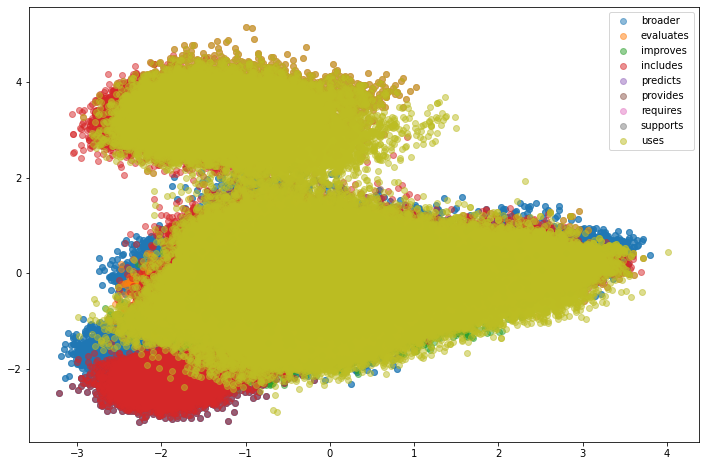

In [89]:
plt.rcParams['figure.figsize'] = [12, 8]

def extractFirstCamel(word):
    if len(word) == 0:
        return ''
    if word[0].isupper():
        return word[0]
    else:
        for i in range(1, len(word)):
            if word[i].isupper():
                return word[:i]
        return word


# visualize the top 2 principal components
fig, ax = plt.subplots()

# He you can set the groups that you are interested in. Use relational_groups to select all groups.
selected_relational_groups = relation_groups 

for i in selected_relational_groups:
    selected_labels = np.where(unified_labels == int(i))
    ax.scatter(transformed[selected_labels, 0], transformed[selected_labels, 1], label=extractFirstCamel(conv_dict[i]), alpha=0.5)
ax.legend()
plt.show()



In [87]:
print('Clustering...')
n_relations=len(selected_relational_groups)

# create selected_transformed_indexes which are indexes of the selected relational groups
selected_transformed_indexes = []
for i in selected_relational_groups:
    selected_transformed_indexes.append(np.where(unified_labels == int(i)))
selected_transformed_indexes = np.concatenate(selected_transformed_indexes, axis=1)[0]
selected_transformed = transformed[selected_transformed_indexes]
kmeans = KMeans(n_clusters=n_relations).fit(selected_transformed)

Clustering...
[     0      1      2 ... 984025 984026 984027]


In [88]:
print('Calculating the score...')
def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print(purity_score(unified_labels[selected_transformed_indexes], kmeans.labels_))

Calculating the score...
0.5329380201823115


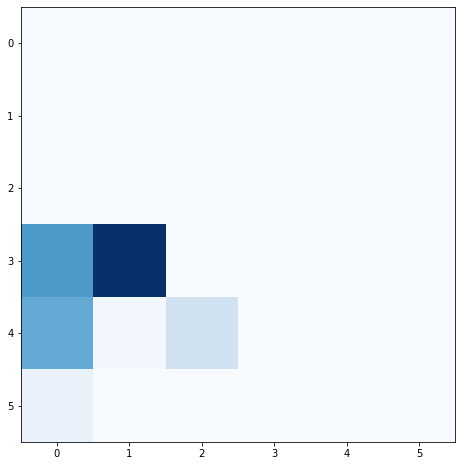

In [84]:
matrix = confusion_matrix(unified_labels[selected_transformed_indexes], kmeans.labels_)
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)